In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(2.25) 

11.1875

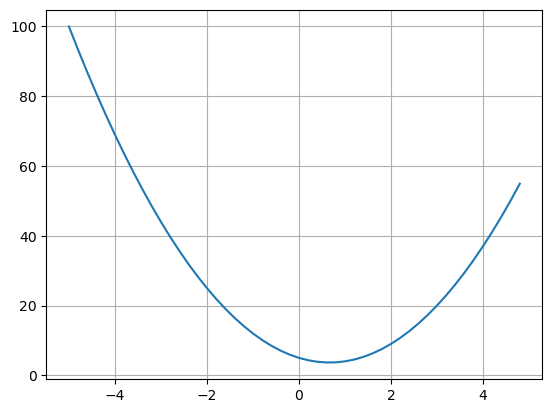

In [5]:
xs = np.arange(-5, 5, 0.2)
ys = f(xs)
plt.plot(xs,ys)
plt.grid(True)

In [6]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x))/h

2.9753977059954195e-07

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [9]:
class Value:
    def __init__(self, data, _children=(), _op='', _label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0
        self._backward = lambda: None
        self._label = _label
        
    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward     
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += out.grad*other*self.data**(other - 1)
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        t = np.tanh(self.data)
        out = Value(t, (self, ), "tanh");
#         x = self.data
#         t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
#         out = Value(t, (self, ), "tanh")
        def _backward():
            self.grad += out.grad*(1 - t**2)
        out._backward = _backward     
        return out
    
    def exp(self):
        x = math.exp(self.data)
        out = Value(x, (self, ), "exp")
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for obj in reversed(topo):
            obj._backward()

In [10]:
a = Value(2.0)
1 * a
a.exp()
b = Value(3)

a - b

Value(data=-1.0)

In [11]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = "svg", graph_attr={'rankdir' : "LR", 'size' : "30,100"})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n._label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

L = d * f
dL/dd = f


dL/dc
dd/dc
d = c + e
    dd/dc = 1
    dd/de = 1.0
    
    dL/dc = dL/dd * dd/dc
    
    dL/da = dL/dd * dd/de * de/da

In [12]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

NameError: name 'L' is not defined

In [13]:
def lol():
    
    h = 0.0001
    a = Value(2.0, _label="a")
    b = Value(-3.0, _label="b")
    c = Value(10.0, _label="c")
    e = a*b; e._label="e";
    d = e + c; d._label="d"
    f = Value(-2.0, _label="f")
    L = d*f; L._label="L";
    L1 = L.data
    
    a = Value(2.0, _label="a")
    b = Value(-3.0, _label="b")
    c = Value(10.0, _label="c")
    e = a*b; e._label="e";
    e.data += h
    d = e + c; d._label="d"
    f = Value(-2.0, _label="f")
    L = d*f; L._label="L";
    L2 = L.data
    
    print((L2 - L1)/h)
    
lol()

-1.9999999999953388


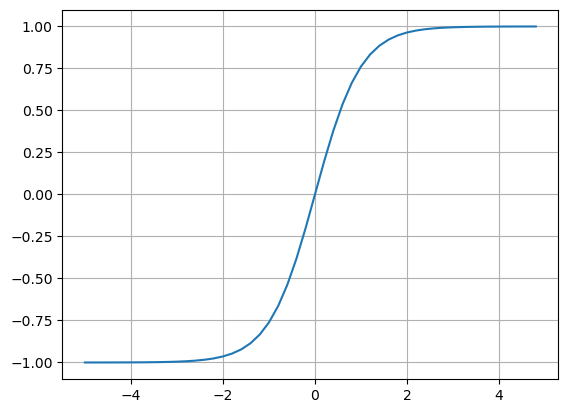

In [14]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid(); 

In [15]:
##perceptron

x1 = Value(0.0); x1._label = "x1"
w1 = Value(2.0); w1._label = "w1"
x2 = Value(-1.0); x2._label = "x2"
w2 = Value(0.5); w2._label = "w2"

w1x1 = x1*w1; w1x1._label="w1x1"
w2x2 = x2*w2; w2x2._label="w2x2"
n = w1x1 + w2x2; n._label="n"
o = n.tanh(); o._label = "o"

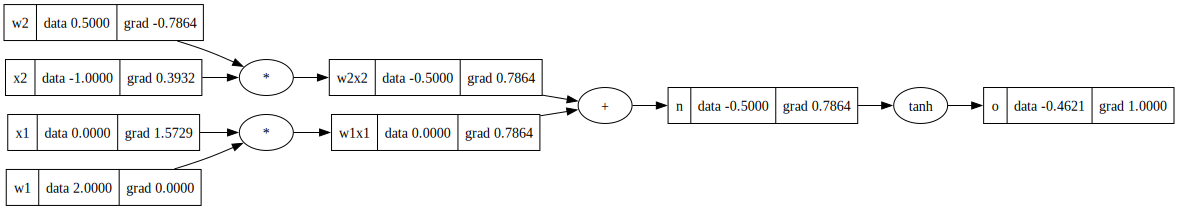

In [16]:
o.backward()
draw_dot(o)

In [17]:
o.grad = 1.0
o._backward()
n._backward()

w2x2._backward()
w1x1._backward()

x1._backward()

In [18]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for obj in reversed(topo):
    obj._backward()

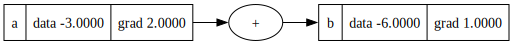

In [19]:
a = Value(-3.0); a._label = "a"
b = a + a; b._label = "b"
b.backward()
draw_dot(b)

In [20]:
##perceptron

x1 = Value(0.0); x1._label = "x1"
w1 = Value(2.0); w1._label = "w1"
x2 = Value(-1.0); x2._label = "x2"
w2 = Value(0.5); w2._label = "w2"
b = Value(0.5433453); b._label = "b"
w1x1 = x1*w1; w1x1._label="w1x1"
w2x2 = x2*w2; w2x2._label="w2x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2._label="w1x1w2x2"
n = w1x1w2x2 + b; n._label = "n"
o = n.tanh(); o._label = "o"

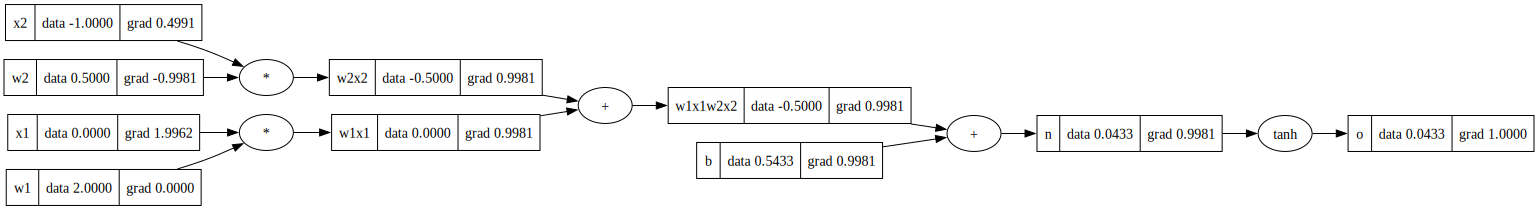

In [21]:
o.backward()
draw_dot(o)

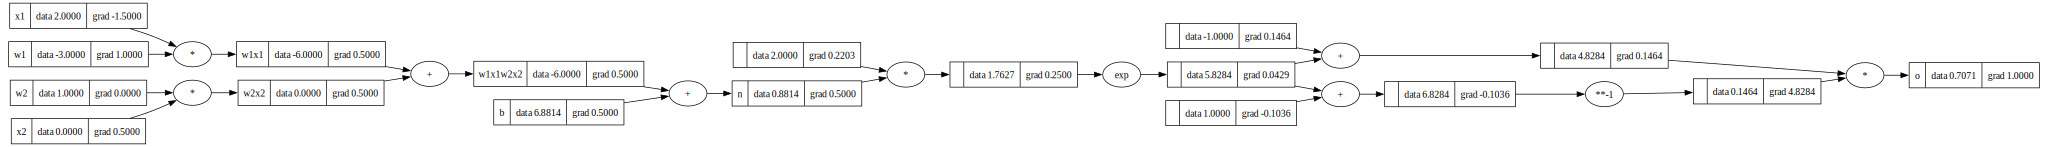

In [22]:
##perceptron

x1 = Value(2.0); x1._label = "x1"
w1 = Value(-3.0); w1._label = "w1"
x2 = Value(0.0); x2._label = "x2"
w2 = Value(1.0); w2._label = "w2"
b = Value(6.8813735870195432); b._label = "b"
w1x1 = x1*w1; w1x1._label="w1x1"
w2x2 = x2*w2; w2x2._label="w2x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2._label="w1x1w2x2"
n = w1x1w2x2 + b; n._label = "n"

p = (2*n).exp()
o = (p - 1)/(p + 1)
o._label = "o"
o.backward()
draw_dot(o)

In [23]:
import torch

In [24]:
x1 = torch.tensor([2.0]).double();   x1.requires_grad = True
x2 = torch.tensor([0.0]).double();   x2.requires_grad = True
w1 = torch.tensor([-3.0]).double();  w1.requires_grad = True
w2 = torch.tensor([1.0]).double();   w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double();  b.requires_grad = True

n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("----")
print("x2", x2.grad.item())
print("x1", x1.grad.item())
print("w2", w2.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
x1 -1.5000003851533106
w2 0.0
w1 1.0000002567688737


In [25]:
x2.grad

tensor([0.5000], dtype=torch.float64)

In [26]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
#         params = []
#         for neuron in self.neurons:
#             k = neuron.parameters()
#             params.extend(k)
#         return params
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        print(sz)
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [27]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

[3, 4, 4, 1]


Value(data=0.9656340597006992)

In [28]:
len(n.parameters())

41

In [29]:
n.parameters()

[Value(data=-0.4040970473517409),
 Value(data=0.5216005575599634),
 Value(data=0.12330257639348297),
 Value(data=0.31644966802577335),
 Value(data=0.007291639792169624),
 Value(data=0.37390589369885885),
 Value(data=-0.9052427794832245),
 Value(data=0.32800358140841746),
 Value(data=-0.20876029447913202),
 Value(data=-0.4726543139485726),
 Value(data=-0.047087438673711235),
 Value(data=-0.5283030653509744),
 Value(data=0.12255627982063988),
 Value(data=-0.17278653260255084),
 Value(data=-0.29771548772085654),
 Value(data=-0.2726214322972069),
 Value(data=-0.10972151406857455),
 Value(data=-0.836626218016256),
 Value(data=0.821476230280412),
 Value(data=-0.8121338025646427),
 Value(data=0.25267045570516955),
 Value(data=-0.2954949347827722),
 Value(data=-0.29037278726447924),
 Value(data=0.20012655100889032),
 Value(data=0.6134066499976718),
 Value(data=-0.4765962288346577),
 Value(data=0.20954637423834144),
 Value(data=0.4846217376073889),
 Value(data=0.8569030321938873),
 Value(data=-

In [30]:
n.layers[0].neurons[0].w[0].grad

0

In [31]:
n.layers[0].neurons[0].w[0].data

-0.4040970473517409

In [32]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, -0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [33]:
#epoch
for k in range(10):
    #forward
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    #flushing grad
    for p in n.parameters():
        p.grad = 0.0
    
    #backward pass
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(f"k:{k}, Loss: {loss}")

k:0, Loss: Value(data=7.423548420385172)
k:1, Loss: Value(data=6.444203776626328)
k:2, Loss: Value(data=1.5633000648428084)
k:3, Loss: Value(data=0.5655508453068118)
k:4, Loss: Value(data=0.301747080229441)
k:5, Loss: Value(data=0.1987971400791581)
k:6, Loss: Value(data=0.14714473943249937)
k:7, Loss: Value(data=0.1163292355983418)
k:8, Loss: Value(data=0.09586519660138049)
k:9, Loss: Value(data=0.081311672142021)


In [34]:
ypred

[Value(data=0.8851639144274505),
 Value(data=-0.912843347665969),
 Value(data=-0.8028689537019467),
 Value(data=0.8528014465704412)]

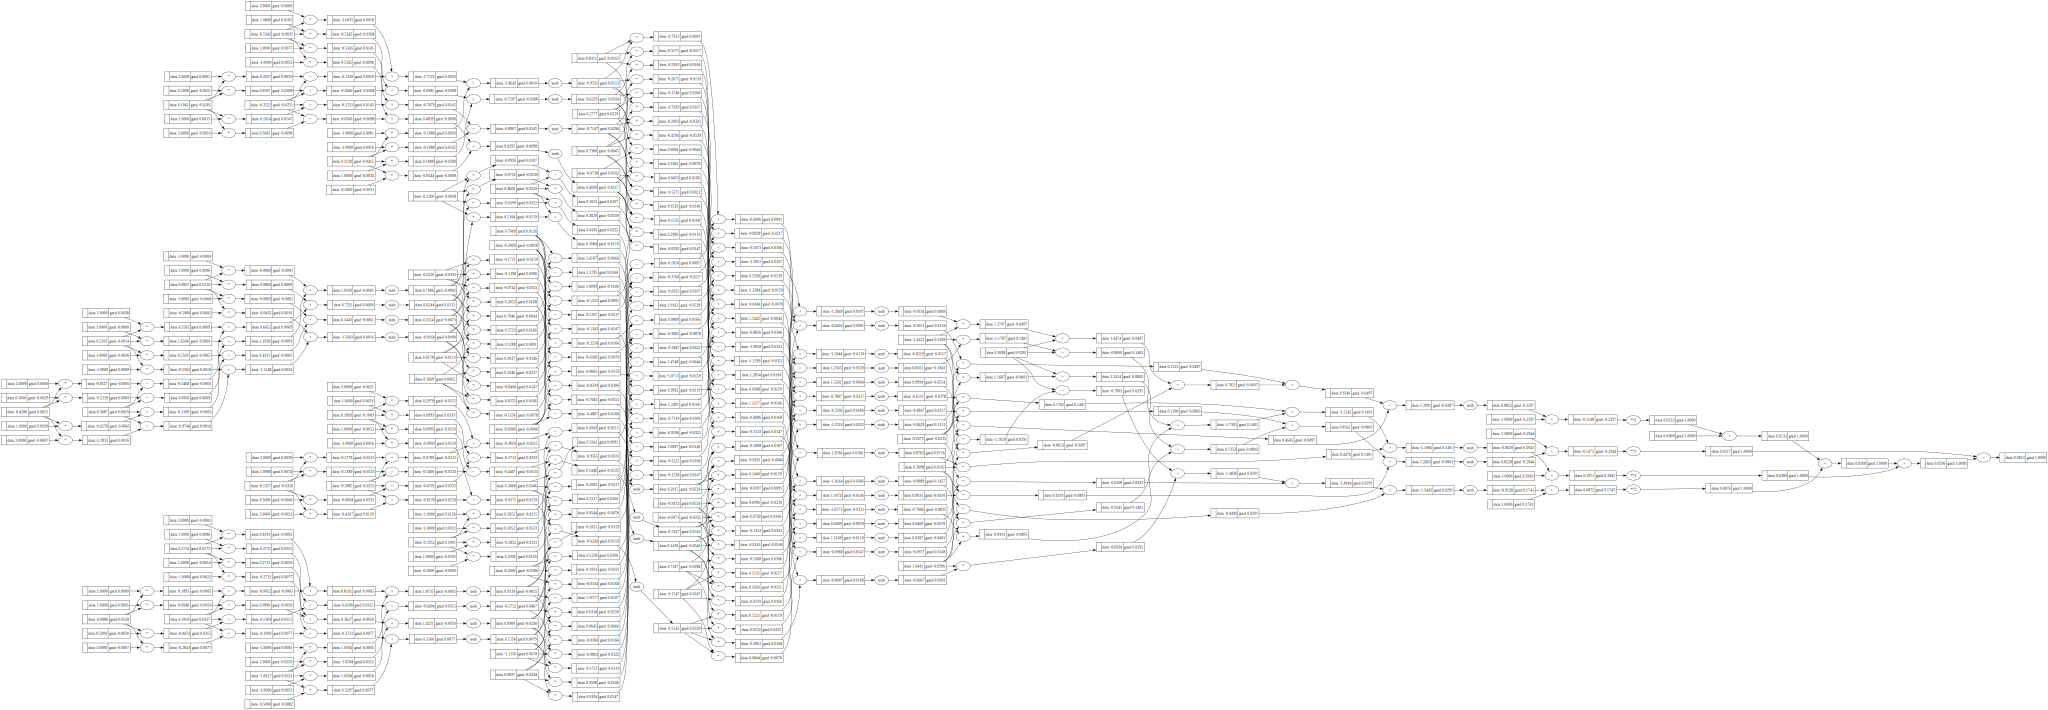

In [35]:
draw_dot(loss)